In [2]:
include("diff_finies.jl")

debug_diff (generic function with 1 method)

Terrain done
Rigidity done
Rigidity inverted
j = 50
j = 100
j = 150
j = 200
j = 250
j = 300
j = 350
j = 400
j = 450
j = 500


┌ Info: Saved animation to 
│   fn = /Users/nacimbouia/MOPSI/tmp.gif
└ @ Plots /Users/nacimbouia/.julia/packages/Plots/w4QRq/src/animation.jl:104


Plots.AnimatedGif("/Users/nacimbouia/MOPSI/tmp.gif")
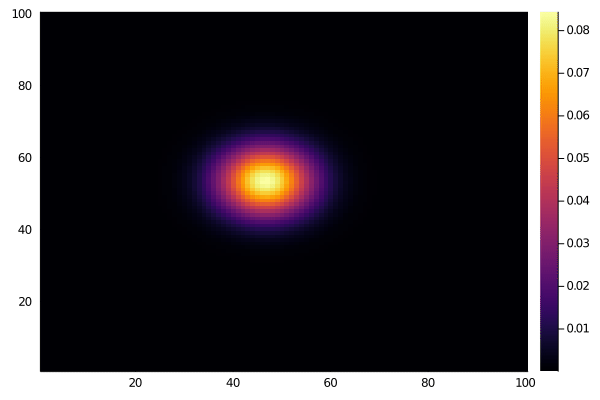

In [3]:
begin
    n = 1
    d = 2n
    C = [1. -1. ; 1. 0.] #Valeurs qui marchent bien
    D = [1.,0.]
    
    L = 15.
    dim = 100
    
    dim_vect = dim * ones(Int,d)
    terrain, step_vect = terrain_parameters_initialisation(L, dim, d)
    println("Terrain done")
    
    rigidity = total_regidity(terrain, step_vect,D,C,dim_vect)
    println("Rigidity done")

    #######
    T = 15.
    J = 500
    time_step = T/J

    K = inv( Matrix(1.0I, vector_dimension(dim_vect), vector_dimension(dim_vect)) - time_step * rigidity )
    println("Rigidity inverted")
    
    #######
    #gaussian2(v::Vector{Float64}) = gaussian(v,[-2,2.]) #Fonctionne bien !
    #gaussian2(v::Vector{Float64}) = gaussian(v,[-2.4,-1.31] )
    gaussian2(v::Vector{Float64}) = gaussian(v, [-0.5,0.5] )
    
    U = gaussian2.(terrain)
    U = U/norm(U)

    U_tab = copy(U)
    @gif for j in 1:J
        if j%50 == 0
            @show j
        end
        show_2D_case(get_last_column(U_tab),dim_vect)
        U_new = K * get_last_column(U_tab)
        U_tab = [U_tab (U_new)]
    end
end

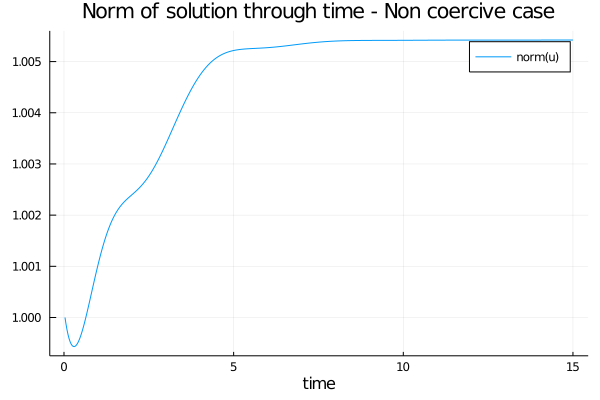

In [19]:
p = plot(time_step * collect(1:J),[norm(U_tab[:,p]) for p in 1:J], xlabel = "time", label = "norm(u)", title = "Norm of solution through time - Non coercive case")

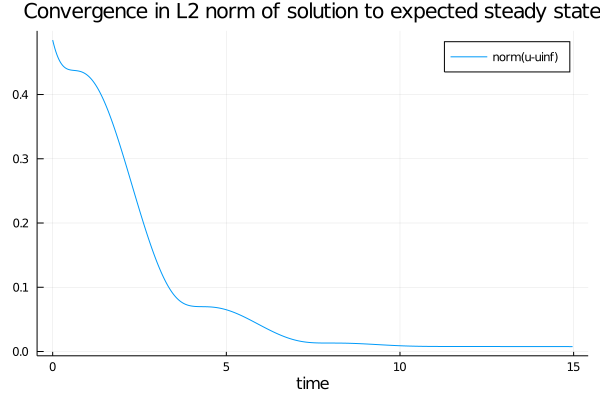

In [30]:
function f_inf(vect::Vector{Float64})::Float64
    x = vect[1]
    y = vect[2]
    #return exp(-(x*x + 2x*y + 2y*y))
    return gaussian(vect)
end

infiniU = f_inf.(terrain)
infiniU = infiniU/norm(infiniU)

p = plot(time_step * collect(0:J-1),[norm(U_tab[:,p] - infiniU) for p in 1:J], xlabel = "time", label = "norm(u-uinf)", title = "Convergence in L2 norm of solution to expected steady state")

savefig("norme de u moins uinf")
p

In [40]:
entropy_generator_1(x::Float64)  = x * log(abs(x)) - x + 1
entropy_generator_2(x::Float64)  = x*x - 1 - 2*(x-1)

start = 25
stop = 300

ite = start:stop
time_frame = time_step * collect(start-1:stop-1)
nothing

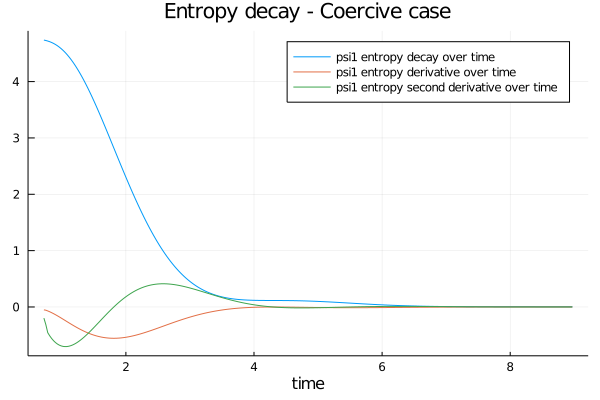

In [44]:
entropy_1 = [sum( (entropy_generator_1.(U_tab[:,p] ./ infiniU)).*infiniU) for p in ite]

p1 = plot(time_frame,entropy_1, xlabel = "time", label = "psi1 entropy decay over time", title = "Entropy decay - Coercive case")

entropy_1_derived = [(entropy_1[i+1] - entropy_1[i-1])/(2time_step) for i in 2:(length(entropy_1)-1)]
entropy_1_derived = 0.2 *[(entropy_1[2] - entropy_1[1])/(time_step); entropy_1_derived; (entropy_1[length(entropy_1)] - entropy_1[length(entropy_1)-1])/(time_step)]
plot!(time_frame,entropy_1_derived, xlabel = "time", label = "psi1 entropy derivative over time")

entropy_1_derived_again = [(entropy_1_derived[i+1] - entropy_1_derived[i-1])/(2time_step) for i in 2:(length(entropy_1_derived)-1)]
entropy_1_derived_again = [(entropy_1_derived[2] - entropy_1_derived[1])/(time_step); entropy_1_derived_again; (entropy_1_derived[length(entropy_1_derived)] - entropy_1_derived[length(entropy_1_derived)-1])/(time_step)]

plot!(time_frame,entropy_1_derived_again, xlabel = "time", label = "psi1 entropy second derivative over time")


#savefig("entropy psi1 over time")



#p2 = plot(collect(1:J),entropy_generator_2.([sum((U_tab[:,p] ./ infiniU).*infiniU) for p in 1:J]), xlabel = "time", ylabel = "entropy psi2 over time")
#savefig("entropy psi2 over time")

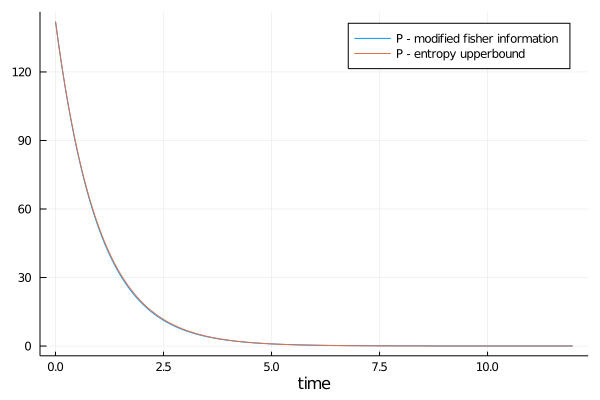

In [36]:
P = [2. -1. ; -1. 2.]

p_norm_squared(vector::Vector{Float64}) = custom_norm_squared(vector,P)

function p_entropy_1_culculation(U_test)
    p_grad = p_norm_squared.(tensor_gradient(U_test ./ infiniU, dim_vect, step_vect)) #.* infiniU
    integrand = ((p_grad .* infiniU) .* infiniU) ./ U_test
    return sum(integrand)
end

p_entropy_1 = [p_entropy_1_culculation(U_tab[:,p]) for p in ite]

p2 = plot(time_frame,p_entropy_1, xlabel = "time", label = "P - modified fisher information")

mu = (eigen(C).values[1]).re
P_entropy_upper_bound_1(x) = p_entropy_1_culculation(U_tab[:,start]) * exp(-2mu * x)

plot!(time_frame,P_entropy_upper_bound_1.(time_frame), xlabel = "time", label = "P - entropy upperbound")
p2



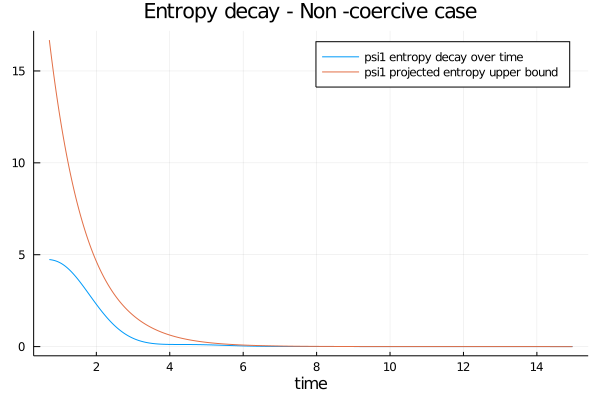

In [24]:
lambda_P = eigen(P).values[1]

entropy_upper_bound_1(x) = (P_entropy_upper_bound_1(x)) / (2lambda_P)

p3 = plot(time_frame,entropy_1, xlabel = "time", label = "psi1 entropy decay over time", title = "Entropy decay - Non -coercive case")
plot!(time_frame,entropy_upper_bound_1.(time_frame), xlabel = "time", label = "psi1 projected entropy upper bound")

#savefig("Entropy decay and P entropy bound - Non -coercive case")


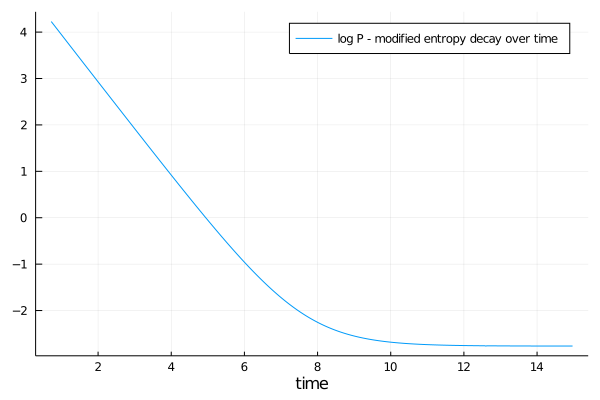

In [25]:
log_p_entropy = log.(p_entropy_1)


p4 = plot(time_frame,log_p_entropy, xlabel = "time", label = "log P - modified entropy decay over time")



In [26]:
time_cut_upper = 2
time_cut_lower = 6

index_cut_upper = Int(floor(time_cut_upper/time_step))
index_cut_lower = Int(floor(time_cut_lower/time_step))

theorical_coefficient =  - (log_p_entropy[index_cut_upper]-log_p_entropy[index_cut_lower])/(time[index_cut_upper]-time[index_cut_lower])/2



LoadError: MethodError: no method matching getindex(::typeof(time), ::Int64)

j = 50
j = 100
j = 150
j = 200
j = 250
j = 300
j = 350
j = 400
j = 450
j = 500


┌ Info: Saved animation to 
│   fn = /Users/nacimbouia/MOPSI/tmp.gif
└ @ Plots /Users/nacimbouia/.julia/packages/Plots/w4QRq/src/animation.jl:104


Plots.AnimatedGif("/Users/nacimbouia/MOPSI/tmp.gif")
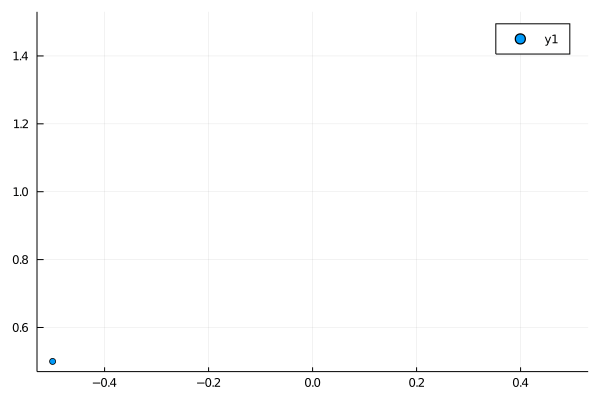

In [15]:
X0 = [-0.5,0.5]
X_tab = copy(X0)

C = [1. -1. ; 1. 0.]

T2 = 15.
J2 = 500
time_step2 = T2/J2

K2 = inv(Matrix(1.0I,2,2) + time_step2*C )

@gif for j in 1:J2
    if j%50 == 0
        @show j
    end
    scatter([get_last_column(X_tab)[1]],[get_last_column(X_tab)[2]])
    X_new = K2 * get_last_column(X_tab)
    X_tab = [X_tab X_new]
end


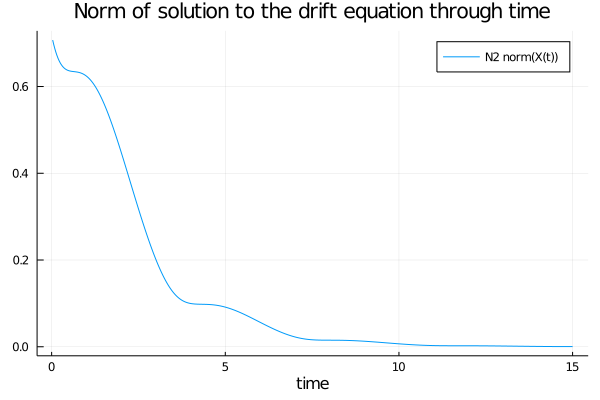

In [43]:
p6 = plot(time_step2 * collect(1:J2),[norm(X_tab[:,p]) for p in 1:J2], xlabel = "time", label = "N2 norm(X(t))", title = "Norm of solution to the drift equation through time")

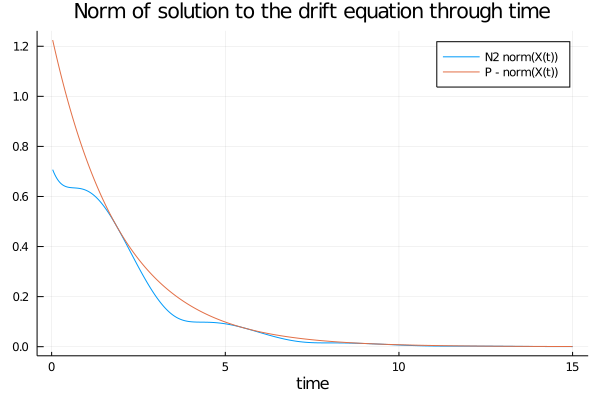

In [44]:
P = [2. -1. ; -1. 2.]

p_norm(vector::Vector{Float64}) = sqrt(custom_norm_squared(vector,P))

plot!(p6, time_step2 * collect(1:J2),[p_norm(X_tab[:,p]) for p in 1:J2], xlabel = "time", label = "P - norm(X(t))", title = "Norm of solution to the drift equation through time")



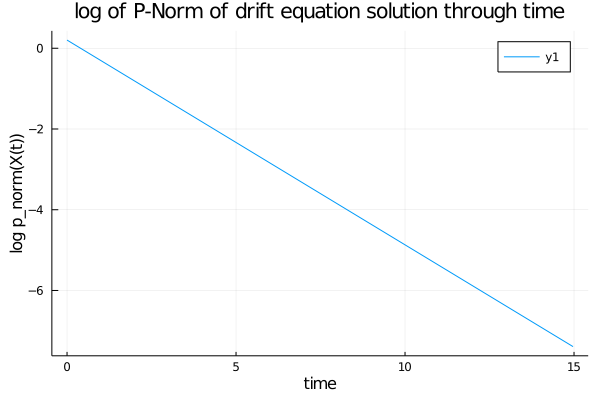

In [38]:
p7 = plot(time_step2 * collect(0:J2-1),log.([p_norm(X_tab[:,p]) for p in 1:J2]), xlabel = "time", ylabel = "log p_norm(X(t))", title = "log of P-Norm of drift equation solution through time")

